# Map gridded heat metrics onto CA census tracts

In [2]:
import geopandas as gpd
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import mapping
from time import time

import rioxarray  # for the extension to load
import rasterio

crs = "EPSG:3310"

In [ ]:
# load geodataframe which maps LOCA grid points to census tracts
xy_census_tracts = gpd.read_file("loca_albers_points_to_geoid.gdb")
xy_census_tracts.set_crs(crs, inplace=True)

# Load census tract shapefile or GeoJSON
census_tracts = gpd.read_file(
    "CA_tiger_2023_tract/"
)  
# GeoDataFrame of census tracts for CA
# subset geodataframe to the minimum of what we need
# so we save memory
census_tracts = census_tracts[["geometry", "GEOID"]]
census_tracts = census_tracts.to_crs(crs)

## Parameters

Convert one metric at a time. Uncomment the metric that is being converted.

In [4]:
# above 90

# ds = xr.open_dataset(
#     "nans_avg_extreme_heat_days_over_90.nc", engine="netcdf4"
# )
# name = "avg annual # extreme heat days above 90 F"

# # above 100

# ds = xr.open_dataset("nans_avg_extreme_heat_days_over_100.nc", engine="netcdf4")
# name = "avg annual # extreme heat days above 100 F"

# # extreme heat

# ds = xr.open_dataset("nans_avg_extreme_heat_days_above_98th_percentile.nc", engine="netcdf4")
# name = "avg annual # extreme heat days above 98th percentile"

# warm nights

ds = xr.open_dataset("nans_avg_warm_nights_above_98th_percentile.nc", engine="netcdf4")
name = "avg annual # warm nights above 98th percentile"

In [ ]:
# reorder the dimensions (necessary for the following chunk to run)
ds = ds.transpose("time_slice_name", "lat", "lon")

In [ ]:
ds.rio.write_crs(
    "EPSG:4326", inplace=True
)  # EPSG for LOCA2: https://analytics.cal-adapt.org/data/access/

# reproject to CA equal albers
ds = ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
ds = ds.rio.reproject(crs)

### Run it

In [7]:
# we want to load the dataset into memory here; it will make future computations much faster
ds = ds.compute()

display(ds)

<xarray.Dataset> Size: 3MB
Dimensions:                                         (x: 311, y: 343,
                                                     time_slice_name: 4)
Coordinates:
  * x                                               (x) float64 2kB -4.129e+0...
  * y                                               (y) float64 3kB 4.56e+05 ...
    time_slice_range                                (time_slice_name) <U9 144B ...
  * time_slice_name                                 (time_slice_name) <U11 176B ...
    quantile                                        float64 8B 0.98
    spatial_ref                                     int64 8B 0
Data variables:
    avg annual # warm nights above 98th percentile  (time_slice_name, y, x) float64 3MB ...

In [ ]:
# convert metric data to geodataframe
gdf_begin_time = time()
df = ds.squeeze().to_dataframe().reset_index().set_index("time_slice_name")
gdf = gpd.GeoDataFrame(data=df[name], geometry=gpd.points_from_xy(df.x, df.y)).set_crs(crs)
gdf_time = time()
print(f"gdf made in {gdf_time-gdf_begin_time} seconds")
display(gdf)

gdf made in 0.3576476573944092 seconds


,avg annual # warm nights above 98th percentile,geometry
time_slice_name,,
past,NaN,POINT (-412932.82 455981.566)
current,NaN,POINT (-412932.82 455981.566)
mid-century,NaN,POINT (-412932.82 455981.566)
end-century,NaN,POINT (-412932.82 455981.566)
past,NaN,POINT (-412932.82 452875.287)
...,...,...
end-century,NaN,POINT (550013.73 -603259.639)
past,NaN,POINT (550013.73 -606365.918)
current,NaN,POINT (550013.73 -606365.918)


<Axes: >

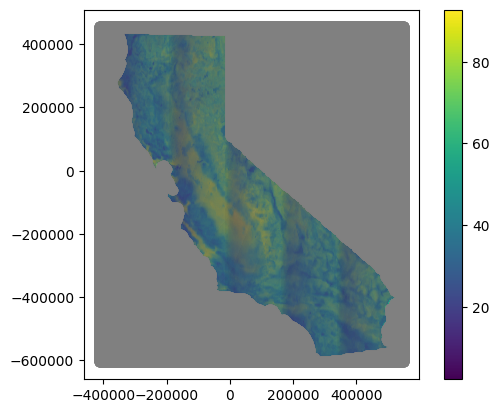

In [9]:
gdf.plot(column=name, legend=True, missing_kwds={"color" : "grey"})

In [ ]:
# join heat metric geodataframe with the geodataframe
# which maps LOCA points to tracts

joined_gdf = (
    xy_census_tracts
    .merge(gdf.reset_index(), on="geometry")
    .set_index("time_slice_name")
)

display(joined_gdf)

,GEOID,geometry,avg annual # warm nights above 98th percentile
time_slice_name,,,
past,06001442700,POINT (-176855.602 -50341.942),3.634314
current,06001442700,POINT (-176855.602 -50341.942),7.376471
mid-century,06001442700,POINT (-176855.602 -50341.942),21.801961
end-century,06001442700,POINT (-176855.602 -50341.942),73.387255
past,06001442800,POINT (-176855.602 -53448.222),3.666667
...,...,...,...
end-century,06013367200,POINT (-204812.114 -3747.754),60.736275
past,06037578100,POINT (174153.947 -469689.634),3.711765
current,06037578100,POINT (174153.947 -469689.634),7.520588


In [11]:
# take the average of grid points in each tract
climate_gdf_tracts_avg = (
    joined_gdf.reset_index().groupby(["GEOID", "time_slice_name"])[[name]].aggregate("mean")
)
climate_gdf_tracts_avg = climate_gdf_tracts_avg.reset_index()

display(climate_gdf_tracts_avg)

,GEOID,time_slice_name,avg annual # warm nights above 98th percentile
0,06001400100,current,7.196078
1,06001400100,end-century,62.801961
2,06001400100,mid-century,18.313725
3,06001400100,past,3.525490
4,06001400200,current,6.806863
...,...,...,...
36511,06115041101,past,2.710013
36512,06115041102,current,11.077941
36513,06115041102,end-century,71.927843
36514,06115041102,mid-century,30.532745


<Axes: >

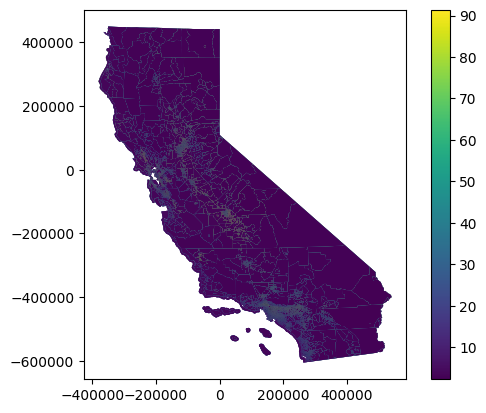

In [12]:
# attach the tract polygons (optional for plotting)
climate_gdf_tracts_plot = (
    census_tracts
    .merge(climate_gdf_tracts_avg, on="GEOID")
    .set_index("time_slice_name")
).set_geometry("geometry")
climate_gdf_tracts_plot.plot(column=name,legend=True)

In [13]:
climate_gdf_tracts_avg[name].max()

91.40686274509802

In [14]:
prelim = climate_gdf_tracts_avg.set_index(["time_slice_name","GEOID"])

In [15]:
# convert into dataset
final_ds = prelim.to_xarray()

## Export

In [84]:
# first, import from local
# final_ds.to_netcdf("census_tract_avg_extreme_heat_days_over_90.nc", engine="netcdf4")
# final_ds.to_netcdf("census_tract_avg_extreme_heat_days_over_100.nc", engine="netcdf4")
# final_ds.to_netcdf(
#     "census_tract_avg_extreme_heat_days_above_98th_percentile.nc", engine="netcdf4"
# )
final_ds.to_netcdf(
    "census_tract_avg_warm_nights_above_98th_percentile.nc", engine="netcdf4"
)